#Задание по программированию: Бэггинг и случайный лес

##Загрузите датасет digits 
с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits). 

Для оценки качества далее нужно будет использовать cross_val_score из sklearn.model_selection с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Мы предлагаем использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

С небольшой вероятностью вы можете натолкнуться на случай, когда полученное вами качество в каком-то из пунктов не попадет в диапазон, заданный для правильных ответов - в этом случае попробуйте перезапустить ячейку с cross_val_score несколько раз и выбрать наиболее «типичное» значение. Если это не помогает, то где-то была допущена ошибка.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs, но будьте осторожны: в одной из старых версий sklearn была ошибка, которая приводила к неверному результату работы cross_val_score при задании n_jobs отличным от 1. Сейчас такой проблемы возникнуть не должно, но проверить, что все в порядке, не будет лишним.

In [28]:
# Импортируем библиотеки
from sklearn import datasets, model_selection, tree, ensemble
import pandas as pd
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
# Загружаем датасет и проверяем его
df = datasets.load_digits()
X = pd.DataFrame(data=df.data)
y = pd.Series(data=df.target)
print(X.head())
print(X.shape)
print(y.head())
print(y.shape)

    0    1    2     3     4     5    6   ...   57   58    59    60    61   62   63
0  0.0  0.0  5.0  13.0   9.0   1.0  0.0  ...  0.0  6.0  13.0  10.0   0.0  0.0  0.0
1  0.0  0.0  0.0  12.0  13.0   5.0  0.0  ...  0.0  0.0  11.0  16.0  10.0  0.0  0.0
2  0.0  0.0  0.0   4.0  15.0  12.0  0.0  ...  0.0  0.0   3.0  11.0  16.0  9.0  0.0
3  0.0  0.0  7.0  15.0  13.0   1.0  0.0  ...  0.0  7.0  13.0  13.0   9.0  0.0  0.0
4  0.0  0.0  0.0   1.0  11.0   0.0  0.0  ...  0.0  0.0   2.0  16.0   4.0  0.0  0.0

[5 rows x 64 columns]
(1797, 64)
0    0
1    1
2    2
3    3
4    4
dtype: int64
(1797,)


In [13]:
# Создаем оценщик качества модели
cv_score = model_selection.cross_val_score

In [79]:
# Функция для записи ответов
def write_answers(name, answer):
    with open(name, "w") as f:
        f.write(str(answer))

##1. Создайте DecisionTreeClassifier 
с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score. Эта величина и будет ответом в пункте 1.

In [80]:
%%time
dtc = tree.DecisionTreeClassifier()
score_DT = cv_score(dtc, X, y, cv=10).mean()
print('Ответ 1:', score_DT)
# Ответ 1
write_answers('ans1.txt', score_DT)

Ответ 1: 0.831346989447548
CPU times: user 265 ms, sys: 4.01 ms, total: 269 ms
Wall time: 273 ms


##2. Воспользуйтесь BaggingClassifier из sklearn.ensemble, 
чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100. 

Качество классификации новой модели - ответ в пункте 2. Обратите внимание, как соотносится качество работы композиции решающих деревьев с качеством работы одного решающего дерева.

CPU times: user 42.2 s, sys: 177 ms, total: 42.4 s
Wall time: 42.2 s


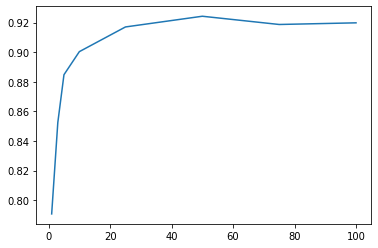

In [69]:
# Зависимость качества модели от количества деревьев
%%time
import seaborn as sns
ns = [1, 3, 5, 10, 25, 50, 75, 100]
sc = []
for n in ns:
    bc_plot = ensemble.BaggingClassifier(n_estimators=n)
    sc.append(cv_score(bc_plot, X, y, cv=10).mean())

sns.lineplot(x=ns, y=sc)

In [81]:
%%time
bc = ensemble.BaggingClassifier(n_estimators=100)
score_BC = cv_score(bc, X, y, cv=10).mean()
print('Ответ 2:', score_BC)
# Ответ 2
write_answers('ans2.txt', score_BC)

Ответ 2: 0.9253848541278709
CPU times: user 15.6 s, sys: 56.7 ms, total: 15.7 s
Wall time: 15.7 s


##3. Теперь изучите параметры BaggingClassifier
 и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt{d}$ случайных признаков. Качество работы получившегося классификатора - ответ в пункте 3. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [82]:
%%time
bc_2 = ensemble.BaggingClassifier(n_estimators=100, max_features=round(X.shape[1] ** .5))
score_BC_2 = cv_score(bc_2, X, y, cv=10).mean()
print('Ответ 3:', score_BC_2)
# Ответ 3
write_answers('ans3.txt', score_BC_2)

Ответ 3: 0.9243109869646183
CPU times: user 4.31 s, sys: 30.9 ms, total: 4.34 s
Wall time: 4.34 s


##4. Наконец, давайте попробуем 
выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же $\sqrt{d}$  признаков. Качество полученного классификатора на контрольной выборке и будет ответом в пункте 4.

In [83]:
%%time
dtc_2 = tree.DecisionTreeClassifier(max_features=round(X.shape[1] ** .5))
bc_3 = ensemble.BaggingClassifier(dtc_2, n_estimators=100)
score_BC_3 = cv_score(bc_3, X, y, cv=10).mean()
print('Ответ 4:', score_BC_3)
# Ответ 4
write_answers('ans4.txt', score_BC_3)

Ответ 4: 0.9465673494723774
CPU times: user 4.39 s, sys: 45.1 ms, total: 4.43 s
Wall time: 4.44 s


##5. RandomForest
Полученный в пункте 4 классификатор - это бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности лучше построить графики зависимости качества от значений параметров, но для сдачи задания это делать не обязательно. 

CPU times: user 21.8 s, sys: 76.8 ms, total: 21.9 s
Wall time: 21.9 s


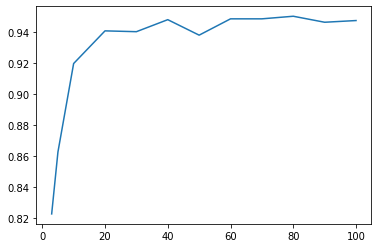

In [68]:
# Зависимость от количества деревьев
%%time
n_estim = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
sc = []
for n in n_estim:
    rf_plot = ensemble.RandomForestClassifier(n_estimators=n, max_features=round(X.shape[1] ** .5))
    sc.append(cv_score(rf_plot, X, y, cv=10).mean())

sns.lineplot(x=n_estim, y=sc)

CPU times: user 1min 33s, sys: 208 ms, total: 1min 33s
Wall time: 1min 33s


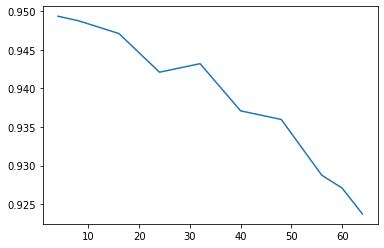

In [75]:
# Зависимость от количества признаков
%%time
max_feat = [4, 8, 16, 24, 32, 40, 48, 56, 60, 64]
sc = []
for n in max_feat:
    rf_plot = ensemble.RandomForestClassifier(n_estimators=100, max_features=n)
    sc.append(cv_score(rf_plot, X, y, cv=10).mean())

sns.lineplot(x=max_feat, y=sc)

CPU times: user 57.6 s, sys: 223 ms, total: 57.8 s
Wall time: 57.7 s


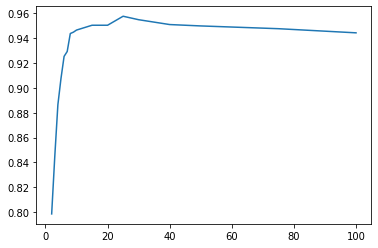

In [76]:
# Зависимость от глубины дерева
%%time
max_d = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 75, 100]
sc = []
for n in max_d:
    rf_plot = ensemble.RandomForestClassifier(n_estimators=100, max_features=round(X.shape[1] ** .5), max_depth=n)
    sc.append(cv_score(rf_plot, X, y, cv=10).mean())

sns.lineplot(x=max_d, y=sc)

In [84]:
%%time
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_features=round(X.shape[1] ** .5))
score_RF = cv_score(rfc, X, y, cv=10).mean()
print('Оценка Случайного леса:', score_RF)

Оценка Случайного леса: 0.9454562383612662
CPU times: user 3.89 s, sys: 17.9 ms, total: 3.91 s
Wall time: 3.92 s


##На основе наблюдений 
выпишите через пробел номера правильных утверждений из приведенных ниже в порядке возрастания номера (это будет ответ в п.5)

1) Случайный лес сильно переобучается с ростом количества деревьев

2) При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев

3) С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.

4) При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.

5) При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.

6) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается.

7) При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).

In [85]:
answer = '2 3 4 7'
write_answers('ans5.txt', answer)